**Imports**


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

tfds.disable_progress_bar() 


Data set


In [ ]:
splits = ['train', 'train[:50%]', 'validation'] 

(raw_train_data, raw_test_data, raw_validation_data), info = tfds.load("food101", split= splits, with_info= True, as_supervised= True)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteGOUZSW/food101-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteGOUZSW/food101-validation.tfrecord
Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
print(num_examples)
print(num_classes)
print(info.features)

75750
101
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})




*   Visulize the Dataset


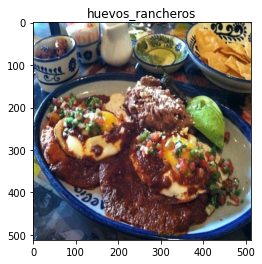

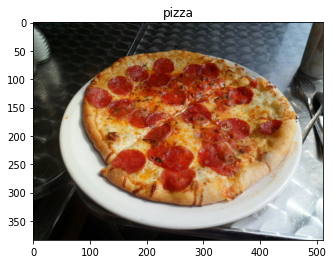

In [ ]:
get_label_name = info.features['label'].int2str
for image, label in raw_train_data.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))



* Create list of labels



In [ ]:
BATCH_SIZE = 32

In [ ]:
IMAGE_SIZE = 224 # using 224 x 224 because that's what the pretrained mobile net model uses 
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # use a 224 x 224 image with rgb for the color data

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0 # normlize data
  return image, label

def augment_image(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0 # normlize data
  image = tf.image.random_flip_left_right(image)
  return image, label


In [ ]:
train_batches = raw_train_data.shuffle(1000).map(augment_image).batch(BATCH_SIZE)
test_batches = raw_test_data.map(format_image).batch(1)
validation_batches = raw_validation_data.map(format_image).batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
do_fine_tuning = True

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape= INPUT_SHAPE, 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)





In [ ]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(1024),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               103525    
Total params: 3,673,253
Trainable params: 3,639,141
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [EarlyStopping(patience=3, restore_best_weights=True), 
           ReduceLROnPlateau(patience=2), 
           ModelCheckpoint(filepath='food_classifier_weights.h5', save_best_only=True)]

history = model.fit(train_batches, epochs=10, validation_data=validation_batches, callbacks=callbacks)

Epoch 1/10
2368/2368 [==============================] - 403s 170ms/step - loss: 2.0641 - accuracy: 0.5098 - val_loss: 1.2236 - val_accuracy: 0.6882 - lr: 0.0010
Epoch 2/10
2368/2368 [==============================] - 397s 168ms/step - loss: 1.2723 - accuracy: 0.6837 - val_loss: 1.0808 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 3/10
2368/2368 [==============================] - 402s 170ms/step - loss: 1.0283 - accuracy: 0.7432 - val_loss: 0.9467 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 4/10
2368/2368 [==============================] - 399s 169ms/step - loss: 0.8610 - accuracy: 0.7842 - val_loss: 0.9770 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 5/10
2368/2368 [==============================] - 400s 169ms/step - loss: 0.7344 - accuracy: 0.8185 - val_loss: 0.9826 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 6/10
1118/2368 [=============>................] - ETA: 3:15 - loss: 0.6034 - accuracy: 0.8534

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

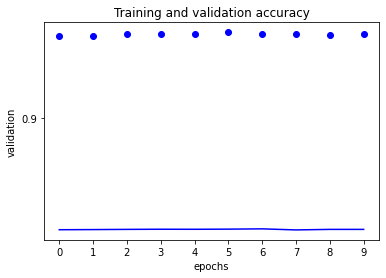

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.xlabel("epochs")
plt.ylabel("validation")
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0,1, .1))
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

### Save the labels to a file


In [ ]:
import re
label_names = info.features['label'].names


with open("labels.txt", 'wt') as labels_file:
  for i in range(len(label_names)):
    name = label_names[i]
    name = re.sub("_", " ", name)
    label_names[i] = name
    labels_file.write(name + "\n")

print(label_names)

['apple pie', 'baby back ribs', 'baklava', 'beef carpaccio', 'beef tartare', 'beet salad', 'beignets', 'bibimbap', 'bread pudding', 'breakfast burrito', 'bruschetta', 'caesar salad', 'cannoli', 'caprese salad', 'carrot cake', 'ceviche', 'cheesecake', 'cheese plate', 'chicken curry', 'chicken quesadilla', 'chicken wings', 'chocolate cake', 'chocolate mousse', 'churros', 'clam chowder', 'club sandwich', 'crab cakes', 'creme brulee', 'croque madame', 'cup cakes', 'deviled eggs', 'donuts', 'dumplings', 'edamame', 'eggs benedict', 'escargots', 'falafel', 'filet mignon', 'fish and chips', 'foie gras', 'french fries', 'french onion soup', 'french toast', 'fried calamari', 'fried rice', 'frozen yogurt', 'garlic bread', 'gnocchi', 'greek salad', 'grilled cheese sandwich', 'grilled salmon', 'guacamole', 'gyoza', 'hamburger', 'hot and sour soup', 'hot dog', 'huevos rancheros', 'hummus', 'ice cream', 'lasagna', 'lobster bisque', 'lobster roll sandwich', 'macaroni and cheese', 'macarons', 'miso sou


### Optional manually test the model using an image of food from the internet



In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = image.img_to_array(img) 
  x = x / 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=512)
  index = np.argmax(classes)
  print("The image is: " + label_names[index])


Saving Hersheys-Perfectly-Chocolate-Chocolate-Cake-13-500x500.jpg to Hersheys-Perfectly-Chocolate-Chocolate-Cake-13-500x500.jpg
The image is: chocolate cake


### Export the model to tflite

In [ ]:
FOOD_SAVED_MODEL = 'food_classifier_model'
tf.saved_model.save(model, FOOD_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: food_classifier_model/assets


INFO:tensorflow:Assets written to: food_classifier_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(FOOD_SAVED_MODEL)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert() 
tflite_model_file = 'food_classifier.tflite'

with open(tflite_model_file, 'wb') as file:
  file.write(tflite_model)


### Test the TFLite Model Using the Python Interpreter

In [ ]:
from tqdm import tqdm

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()


input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(input_index)
print(output_index)
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(101)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

NameError: ignored

In [ ]:
# visulize the results make sure they work using the tensorflow lite interpreter. 
# this part of the code came from the tensorflow lite course on coursera.
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                         100*np.max(predictions_array),
                                         label_names[true_label]), color=color)


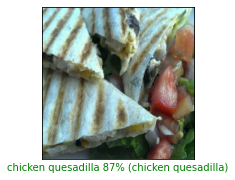

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 49 #@param {type:"slider", min:0, max:100, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

### Download the tflite file

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!mkdir -p test_images

from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.bmp'.format(label_names[label[0]], index))

!ls test_images
!zip -qq food_test_images.zip -r test_images/

 baklava_28.bmp		     'greek salad_31.bmp'
'beef tartare_14.bmp'	      hamburger_9.bmp
'bread pudding_30.bmp'	     'huevos rancheros_0.bmp'
'breakfast burrito_49.bmp'    lasagna_21.bmp
 bruschetta_4.bmp	     'lobster roll sandwich_38.bmp'
'caesar salad_17.bmp'	     'lobster roll sandwich_41.bmp'
'caesar salad_37.bmp'	     'miso soup_3.bmp'
'chicken curry_20.bmp'	      omelette_40.bmp
'chicken quesadilla_13.bmp'  'pad thai_15.bmp'
'chicken quesadilla_39.bmp'  'pad thai_5.bmp'
'chocolate cake_2.bmp'	     'panna cotta_10.bmp'
'chocolate cake_45.bmp'       pizza_1.bmp
'chocolate cake_8.bmp'	      pizza_23.bmp
'chocolate mousse_24.bmp'     pizza_26.bmp
 churros_32.bmp		     'pork chop_16.bmp'
'clam chowder_47.bmp'	     'prime rib_43.bmp'
'cup cakes_48.bmp'	     'pulled pork sandwich_22.bmp'
'deviled eggs_42.bmp'	      risotto_33.bmp
 edamame_11.bmp		      risotto_35.bmp
 edamame_27.bmp		     'shrimp and grits_46.bmp'
'eggs benedict_36.bmp'	     'spaghetti bolognese_6.bmp'
'filet mignon_12.b

In [ ]:
from google.colab import files
try:
    files.download('food_test_images.zip')
except:
  
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>